In [50]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

from torch import Tensor
from torch.nn.parameter import Parameter, UninitializedParameter
from typing import Optional
from torch.utils.data import DataLoader, TensorDataset

We write classes for linear and singular models that we are going to use train SGD

In [76]:
class SingModel(torch.nn.Module):
    def __init__(self, w0:float, d1:int, d2:int, in_features:int, 
                 out_features:int, w_init: Optional[Tensor] = None) -> None:
         super(SingModel, self).__init__()
         self.w0 = w0
         self.d1 = d1
         self.d2 = d2
         if w_init is not None:
            self.weight = torch.nn.Parameter(w_init)
         else:
            self.weight = torch.nn.Parameter(torch.randn((out_features, in_features)))

         
    def forward(self, input:Tensor):
        sing1 = (self.weight + self.w0)**self.d1
        sing2 = (self.weight - self.w0)**self.d2
        return input * sing1 * sing2

# Defining the Linear Model
class LinearModel(nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(1, 1)
        # Random weight initialization
        self.linear.weight.data.normal_()
    def forward(self, x):
        return self.linear(x)
    
# Training model

def train_model(model, data_loader, w_init: Optional[Tensor] = None, 
                linear=True, num_epochs = 1000, lr=0.01):
    # Loss tracking
    loss_values = []

    # Tracking weights
    if w_init is None:
         weights_over_epochs = []
    else:
         weights_over_epochs = [w_init.item()]

    # Loss and Optimizer
    loss_function = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)

    # Training the Model
    for epoch in range(num_epochs):
        for batch_x, batch_y in data_loader:
            # Forward pass
            y_pred = model(batch_x)
            loss = loss_function(y_pred, batch_y)

            # Backward pass and optimization
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Tracking loss and weight along epochs
        loss_values.append(loss.item())
        if linear == True:
            current_weight = model.linear.weight.item()
        else:
            current_weight = model.weight.item() 
        weights_over_epochs.append(current_weight)

        if epoch % 10 == 0:
                        print(f'Epoch {epoch}, Loss: {loss.item()}, w: {current_weight}')
    return loss_values, weights_over_epochs

# Plot loss curve

def plot_loss_curve(loss_values):
    plt.plot(loss_values)
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

# Plot loss landscape

def plot_loss_landscape(model, x_data, y_data, 
                        weight_range, weights_over_epochs, linear=False):

    # Computing the loss for each weight value in the range
    loss_landscape = []
    loss_function = nn.MSELoss()

    for weight in weight_range:
        # Updating the model's weight and fixed bias
        if linear == True:
            model.linear.weight.data.fill_(weight)
        else:
            model.weight.data.fill_(weight) 
        
        # Forward pass with the updated weight
        y_pred = model(x_data)
        
        # Computing the loss
        loss = loss_function(y_pred, y_data)
        loss_landscape.append(loss.item())

    # Plotting the loss landscape
    
    plt.plot(weight_range, loss_landscape, label='Loss Landscape')

    # Plotting the trajectory of the weights during training
    plt.plot(weights_over_epochs, [loss_landscape[np.argmin(np.abs(weight_range - w))] for w in weights_over_epochs], 'ro-', label='Training Path', markersize=3)
    plt.title('Weight Dynamics on Loss Landscape')
    plt.yscale("log")
    plt.xlabel('Weight')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


Train a Linear model and visualise the loss curve and visualise the training dynamics on the loss landscape (for sanity check)

Epoch 0, Loss: 2.0651631355285645, w: 1.2202140092849731
Epoch 10, Loss: 0.8792300224304199, w: 0.6520211100578308
Epoch 20, Loss: 1.2284082174301147, w: 0.3515891134738922
Epoch 30, Loss: 1.6105549335479736, w: 0.19624753296375275
Epoch 40, Loss: 1.0112757682800293, w: 0.11266319453716278
Epoch 50, Loss: 2.039031982421875, w: 0.06886370480060577
Epoch 60, Loss: 0.672309398651123, w: 0.0453110933303833
Epoch 70, Loss: 1.1339004039764404, w: 0.03254609555006027
Epoch 80, Loss: 0.4684867858886719, w: 0.026899537071585655
Epoch 90, Loss: 0.8394964933395386, w: 0.023216458037495613


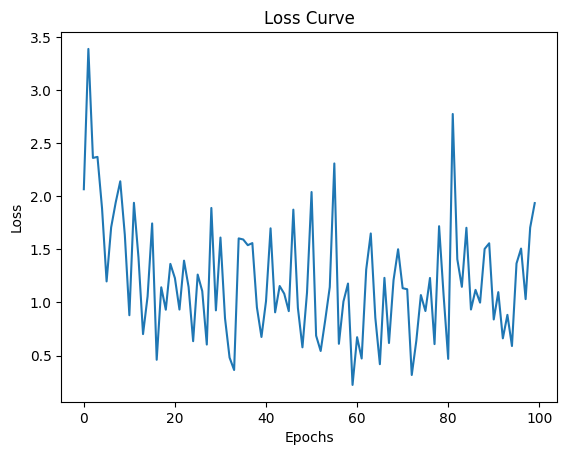

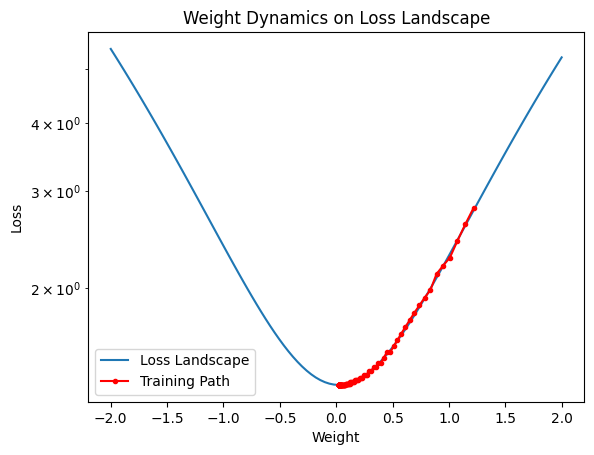

In [83]:
# Parameters
torch.manual_seed(42) # for reproducibility
num_samples = 1000
num_epochs = 100
batch_size = 32
lr = 0.001

x_data = torch.normal(0, 1, (num_samples, 1))
y_data = torch.normal(0, 1, (num_samples, 1))
dataset = TensorDataset(x_data, y_data)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Train function
model = LinearModel()
loss_values, weights_over_epochs =  train_model(model, data_loader, num_epochs = num_epochs, lr=lr)
plot_loss_curve(loss_values)

# Plot loss landscape
weight_range = np.linspace(-2, 2, 100)
model = LinearModel()
plot_loss_landscape(model, x_data, y_data, 
                        weight_range, weights_over_epochs, linear=True)

Train a singular model, plot loss curve and loss landscape

Epoch 0, Loss: 1.5163620710372925, w: 1.443454623222351
Epoch 10, Loss: 0.9818235635757446, w: 1.315159559249878
Epoch 20, Loss: 1.6853021383285522, w: 1.2799756526947021
Epoch 30, Loss: 1.217824935913086, w: 1.2604564428329468
Epoch 40, Loss: 0.8583781123161316, w: 1.2473583221435547
Epoch 50, Loss: 1.035634160041809, w: 1.2377138137817383
Epoch 60, Loss: 1.2754936218261719, w: 1.2301859855651855
Epoch 70, Loss: 1.3583003282546997, w: 1.224110722541809
Epoch 80, Loss: 1.0507731437683105, w: 1.2190488576889038
Epoch 90, Loss: 1.3818557262420654, w: 1.2147480249404907


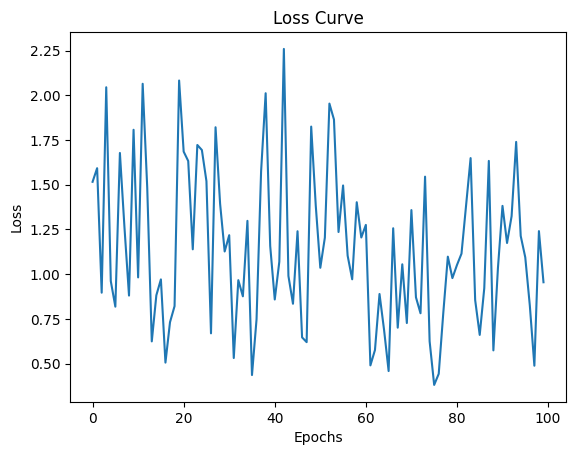

1.5


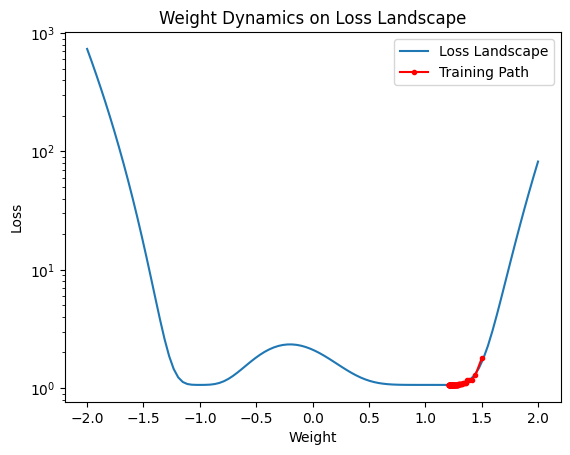

In [97]:
# Pramaters
lr = 0.0001
w_init = 1.5
num_epochs = 100
num_samples = 1000
batch_size = 10

# Generate data
w_init = torch.Tensor([[w_init]])
torch.manual_seed(42) # for reproducibility
x_data = torch.normal(0, 1, (num_samples, 1))
y_data = torch.normal(0, 1, (num_samples, 1))
dataset = TensorDataset(x_data, y_data)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Training
model = SingModel(w0=1.0, d1=2, d2=3, in_features=1, out_features=1, w_init=w_init)
loss_values, weights_over_epochs =  train_model(model, data_loader, w_init=w_init,
                                                linear=False, num_epochs = num_epochs, lr=lr)
plot_loss_curve(loss_values)
print(weights_over_epochs[0])

# Plot loss landscape
weight_range = np.linspace(-2, 2, 100)
model = SingModel(w0=1.0, d1=2, d2=3, in_features=1, out_features=1, w_init=w_init)  # create a model instance
plot_loss_landscape(model, x_data, y_data, 
                        weight_range, weights_over_epochs, linear=False)

Calculate Bayesian posterior